# Axon growth quantification

In [1]:
import napari
import numpy as np
import re
from glob import glob
import os
from natsort import natsorted
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

viewer = napari.Viewer() # open napari viewer

Next cell will open the swc files from the folder and save them in the readable for Python format. Be sure to correctly specify the folder name! 

In [2]:
folder_name = 'axon_tracing'  # TO DO: here check if the folder name is correct, if not - change it. 
#if folder_name.len() < 1:
        #folder_name = 'axon_tracing'

files =  os.listdir(folder_name + '/') 
files = natsorted(files)

axons = [] # the array that would keep information about axons, their coordinates. 

for file in enumerate(files):
    # load parse the data
    with open(folder_name + '/' + file[1], 'r') as f: # read swc as txt file
        data = f.read()

    lines = [line for line in data.split('\n') if re.match(r"^\d+.*$",line)] # split into lines and take only lines that start with a number
    coords = [np.array(w.split('\t')[2].split(' ')[:2], dtype=float) for w in lines if re.match(r"^\d+.*$",w)]
    axon = np.array(coords)
    # axon = axon[:, [1, 0]]
    axons.append(axon)

print('Number of time points is', len(axons))

Number of time points is 8


Next cell would shift origins of axons from different time points to the one point. 

In [3]:
# shift the axons to the single origin
origin = axons[0][0]
shifted_axons = [axons[0]]

# subtract the origin from each axon
for i, axon in enumerate(axons):
    if i == 0: continue
    diff = axon[0] - origin
    shifted_axon = np.array([coord - diff for coord in axon])
    shifted_axons.append(shifted_axon)

# move origin to 0
shifted_axons = [axons - origin for axons in shifted_axons]
    
print('Axons from different time points were shifted to the same origin')

Axons from different time points were shifted to the same origin


Next cell will visualize all axons from different time points, each with unique color in the open Viewer.

In [4]:
# vizualize axons
for i, axon in enumerate(shifted_axons):
    # generate new color
    color = np.random.rand(3)
    viewer.add_shapes(axon, name=f'axon t ={i+1}', shape_type='path', ndim = 2, edge_width=1, edge_color=color, face_color=color)

In [5]:
# vizualize the growth
growth = np.array( [axon[-1] for axon in shifted_axons])
viewer.add_shapes(growth, name='growth path', shape_type='path', ndim = 2, edge_width=1, edge_color='green', face_color='green')
viewer.add_points(growth, size=1, face_color='green')


# save growth to csv
#growth_df = pd.DataFrame(growth)
#growth_df.to_csv('growth.csv')

<Points layer 'growth' at 0x215cac77a30>

The below cell would compute the required parameters for each time point.

In [7]:
#output file name
#outputfile = input('Enter the name of the output file: ')
measurements = defaultdict(list) # set measurements dictionary

origin = shifted_axons[0][0] # set origin
prev_tip = origin

for i, axon in enumerate(shifted_axons):
    current_time = 900 * i
    print('time:', current_time)
    measurements['Time'].append(current_time) # add time to measurements

    # add coords to measurements
    print('last tip is', axon[-1])
    measurements['Coordinate of the tip node'].append(axon[-1])

    # compute the distance between first and last coord and add it to measurements
    axon_length = np.linalg.norm(origin - axon[-1])
    print('axon growth at time', current_time, 'is', axon_length)
    measurements['Axon length ($\mu m$)'].append(axon_length)

    current_tip = axon[-1]
    
    if i == 0:
        growth_dist = 0
        speed = 0
        angle = 0
    else: 
        growth_dist = np.linalg.norm(current_tip - prev_tip)
        speed = growth_dist / (current_time - prev_time)
        
        prev_prev_tip = shifted_axons[i - 2][-1] if i >= 2 else origin

        x = prev_prev_tip - prev_tip
        x = x / np.linalg.norm(x)

        y = current_tip - prev_tip
        y = y / np.linalg.norm(y)

        angle = np.degrees(np.arccos(x @ y))

    # add speed to measurements
    print('speed of growth at time', current_time, 'is', speed)
    measurements['Speed from $t_{i-1}$ to $t_{i}$ ($\mu m / \text{sec}$)'].append(speed)
    measurements['Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\mu m$)'].append(growth_dist)
    
    
    print('angle change at time', current_time, 'is', angle)
    measurements['Angle change from $t_{i-1}$ to $t_{i}$ (%)'].append(angle)
    
    prev_tip = current_tip
    prev_time = current_time


total_growth = np.linalg.norm(axons[-1][-1] - axons[0][-1])
total_speed = total_growth / current_time

# compute total angle change
x = shifted_axons[0][-1]
x = x / np.linalg.norm(x)

y = shifted_axons[-1][-1]
y = y / np.linalg.norm(y)

angle = np.degrees(np.arccos(x @ y))

measurements = pd.DataFrame(measurements)
measurements['Total growth during all time ($\mu m$)'] = total_growth
measurements['Total speed during all time ($\mu m / \text{sec}$)'] = total_speed
measurements['Total angle change (%)'] = angle

measurements.to_csv('measurements.csv')
measurements

time: 0 <class 'int'>
last tip is [-12.011393  17.062913]
axon growth at time 0 is 20.866637530901265
speed of growth at time 0 is 0
angle change at time 0 is 0
time: 900 <class 'int'>
last tip is [-16.61389   25.145346]
axon growth at time 900 is 30.138177887719348
speed of growth at time 900 is 0.010334450467361261
angle change at time 900 is 174.51558169744104
time: 1800 <class 'int'>
last tip is [-20.318338  31.992962]
axon growth at time 1800 is 37.89966327839455
speed of growth at time 1800 is 0.008650467757863007
angle change at time 1800 is 178.75354990227237
time: 2700 <class 'int'>
last tip is [-24.022786  35.136131]
axon growth at time 2700 is 42.563387422184306
speed of growth at time 2700 is 0.005398038778199397
angle change at time 2700 is 158.72677059625053
time: 3600 <class 'int'>
last tip is [-30.084611  47.147525]
axon growth at time 3600 is 55.92828383427249
speed of growth at time 3600 is 0.014949268455360801
angle change at time 3600 is 157.09294952460215
time: 450

PermissionError: [Errno 13] Permission denied: 'measurements.csv'

Next cell is not compulsory and can be used to visualize the computed data.

<AxesSubplot:xlabel='Time', ylabel='Axon length ($\\mu m$)'>

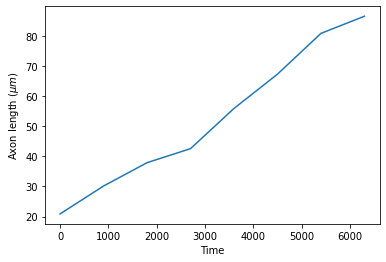

In [7]:
# visualize the data
sns.lineplot(data=measurements, x="Time", y='Axon length ($\mu m$)')

<AxesSubplot:xlabel='Time', ylabel='Speed from $t_{i-1}$ to $t_{i}$ ($\\mu m / \text{sec}$)'>

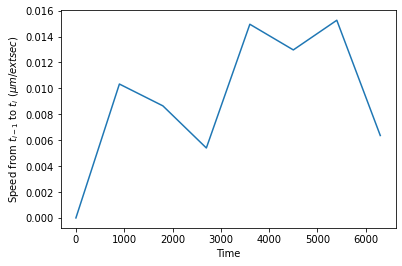

In [8]:
sns.lineplot(data=measurements, x="Time", y='Speed from $t_{i-1}$ to $t_{i}$ ($\mu m / \text{sec}$)')

<AxesSubplot:xlabel='Time', ylabel='Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\\mu m$)'>

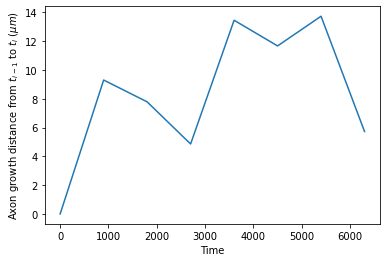

In [9]:
sns.lineplot(data=measurements, x="Time", y='Axon growth distance from $t_{i-1}$ to $t_{i}$ ($\mu m$)')

<AxesSubplot:xlabel='Time', ylabel='Angle change from $t_{i-1}$ to $t_{i}$ (%)'>

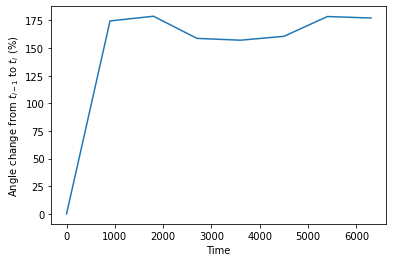

In [10]:
sns.lineplot(data=measurements, x="Time", y='Angle change from $t_{i-1}$ to $t_{i}$ (%)')